# Image Checking of pMDI Spray Images

This program reads output of image preprocessing script and attempts to define the spray spatial and temporay boundary.

    @author Daniel Duke <daniel.duke@monash.edu>
    @copyright (c) 2024 D.Duke
    @license GPL-3.0+
    @version 0.0.1
    @date 03/02/2025
    
    Multiphase Flow Laboratory
    Monash University, Australia


In [1]:
import numpy as np
import h5py
from scipy import ndimage
#import glob, sys, os, copy, gc, time
from tqdm.notebook import tqdm

In [2]:
import matplotlib.pyplot as plt
%matplotlib widget

In [3]:
filename="/Users/dduke/Desktop/20kHz_896x920_134_0.3Or08L_cone901.3Dep_MK6__S0001.h5"

In [4]:
# Open up file and leave it open for reading frames on the fly (save RAM).
H=h5py.File(filename,'r')
data=H['bkgnd_removed_images/Iproc']
print(data.shape)

(5177, 920, 896)


## Attempt automatic threshold detection
Require that the total area bounded by the threshold region is not over the whole image.
Require that the number of pixels in the threshold criteria is not too small.

I think the threshold for the spray is 0.018813


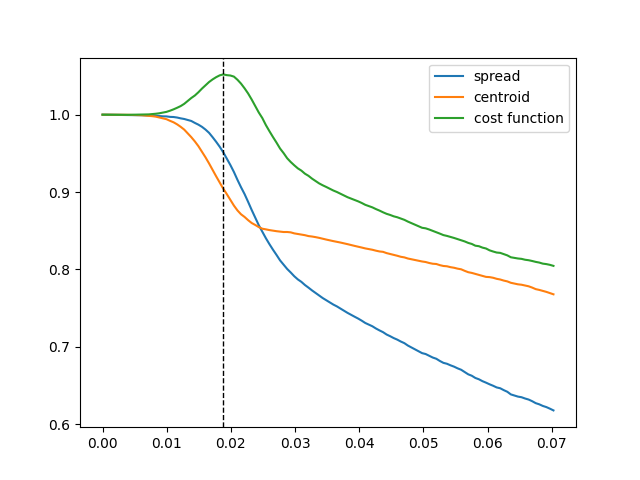

In [20]:
# Take a frame where there is a lot of spray (time-minimum?)
frame=data[1100,...];
thresholds = np.linspace(0,np.nanmean(frame)+2*np.nanstd(frame),128)
center=[]
spread=[]
NN=np.prod(frame.shape)
for t_ in thresholds:
    thr=frame>t_
    thr = ndimage.binary_dilation(thr,iterations=3) 
    thr = ndimage.binary_erosion(thr,iterations=3) 
    idx=np.where(thr)
    center.append(np.nanmean(np.ravel(idx))) # centroid of the thresholded region 
    spread.append(np.nanstd(np.ravel(idx))) # ~size of the thresholded region
    
fig=plt.figure()
plt.plot(thresholds, np.array(spread) / spread[0] , label='spread');
plt.plot(thresholds, np.array(center) / center[0] , label='centroid');
s=center[0]*np.array(spread)/(np.array(center) * spread[0]) # metric requires large size and low centroid
plt.plot(thresholds, s ,label='cost function');
threshold = thresholds[np.where(s==np.nanmax(s))[0][0]]
plt.axvline(threshold,c='k',ls='--',lw=1);
plt.legend();
print('I think the threshold for the spray is %f' % threshold);

## Plot result

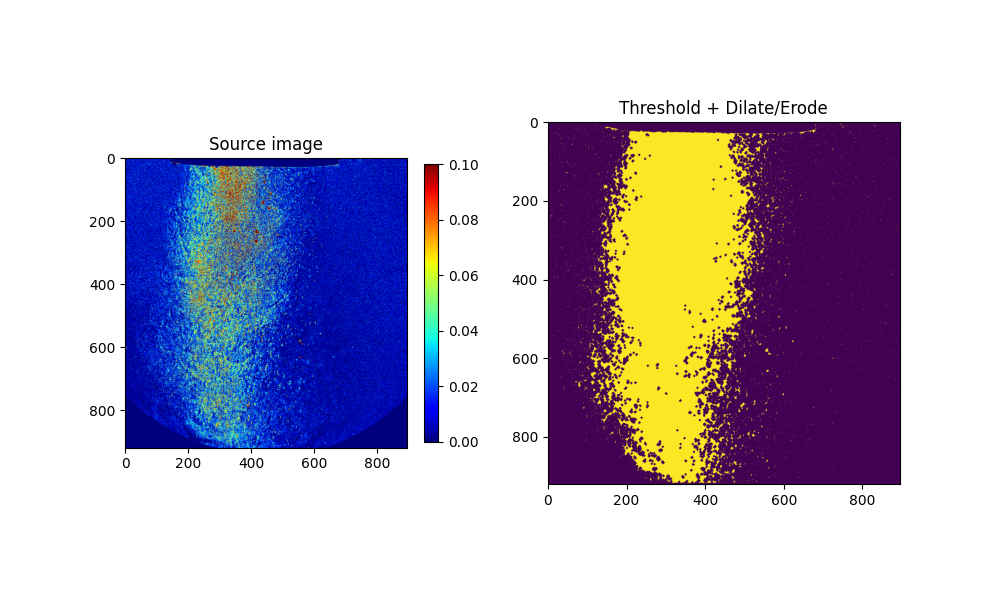

In [22]:
fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(121)
p=plt.imshow(frame,cmap='jet',vmin=0,vmax=0.1);
plt.colorbar(p,shrink=.6);
plt.title("Source image");

ax=fig.add_subplot(122)
thr=frame>threshold*2
thr = ndimage.binary_dilation(thr,iterations=3) 
thr = ndimage.binary_erosion(thr,iterations=3) 
p=plt.imshow(thr);
plt.title("Threshold + Dilate/Erode");

In [13]:
Isum = np.zeros_like(data[0,...])
n=0
for i in tqdm(range(data.shape[0])):
    frame = data[i,...]
    frame[frame<0.02]=0
    frame[frame>0.98]=0.98
    Isum += frame
    n+=1

  0%|          | 0/5177 [00:00<?, ?it/s]

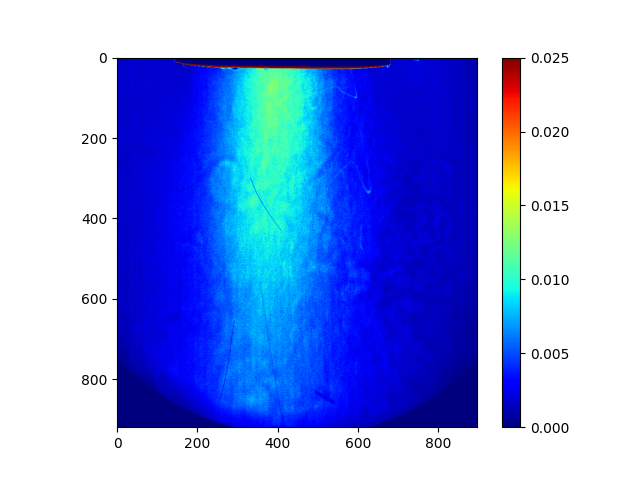

In [14]:
fig=plt.figure()
p=plt.imshow(Isum/float(n),cmap='jet',vmin=0,vmax=0.025);
plt.colorbar(p);